# Black Box Data Analysis

## Previous Notebooks

- [Data Ingestion and Cleaning](1-Data Ingestion and Cleaning.ipynb)
- [EDA](2-EDA.ipynb)
- [Apriori](3-Apriori.ipynb)
- [Clustering on the Cloud](4a-Clustering on Cloud.ipynb)
- [Clustering on Premises](4b-Clustering on Prem.ipynb)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Interpreting Labels

In this notebook I look at the clusters obtained using ranges determined from quantiles and try to interpret them in terms of the clients' behaviours they capture and to assess the value of the clustering in terms of the information it can give to the company.

In [2]:
vouchers = pd.read_csv('./data/processed/voucher.csv')
vou_apriori = pd.read_pickle('./data/processed/final_clustering.pkl')

![COR](./reports/figures/COR_quant.png)

### Centroids

First let's take a look at the centroids (to be precise the closest time series to each centroid) and try to infer something about the type of clients in each cluster.

In [3]:
for i in range(10):
    col = 'dist{}'.format(i)
    print(vou_apriori[col].idxmin())

(2462524, 2014)
(2564597, 2016)
(3519007, 2015)
(4973436, 2016)
(3695016, 2015)
(2784382, 2015)
(4817505, 2015)
(3834021, 2015)
(3196994, 2014)
(3154794, 2016)


I used this query to retrieve the data with [Google BigQuery](https://cloud.google.com/bigquery/):

```SQL
SELECT
  n_voucher
  ,annuality
  ,start_date
  ,km_day
FROM
  ``k2project-201805.trips.dataset2``
WHERE
  (n_voucher = '2462524' AND annuality = 2014)
  OR (n_voucher = '2564597' AND annuality = 2016)
  OR (n_voucher = '3519007' AND annuality = 2015)
  OR (n_voucher = '4973436' AND annuality = 2016)
  OR (n_voucher = '3695016' AND annuality = 2015)
  OR (n_voucher = '2784382' AND annuality = 2015)
  OR (n_voucher = '4817505' AND annuality = 2015)
  OR (n_voucher = '3834021' AND annuality = 2015)
  OR (n_voucher = '3196994' AND annuality = 2014)
  OR (n_voucher = '3154794' AND annuality = 2016)
```

In [4]:
centroids = pd.read_csv('./data/processed/centroids.csv')
centroids['start_date'] = pd.to_datetime(centroids['start_date'])

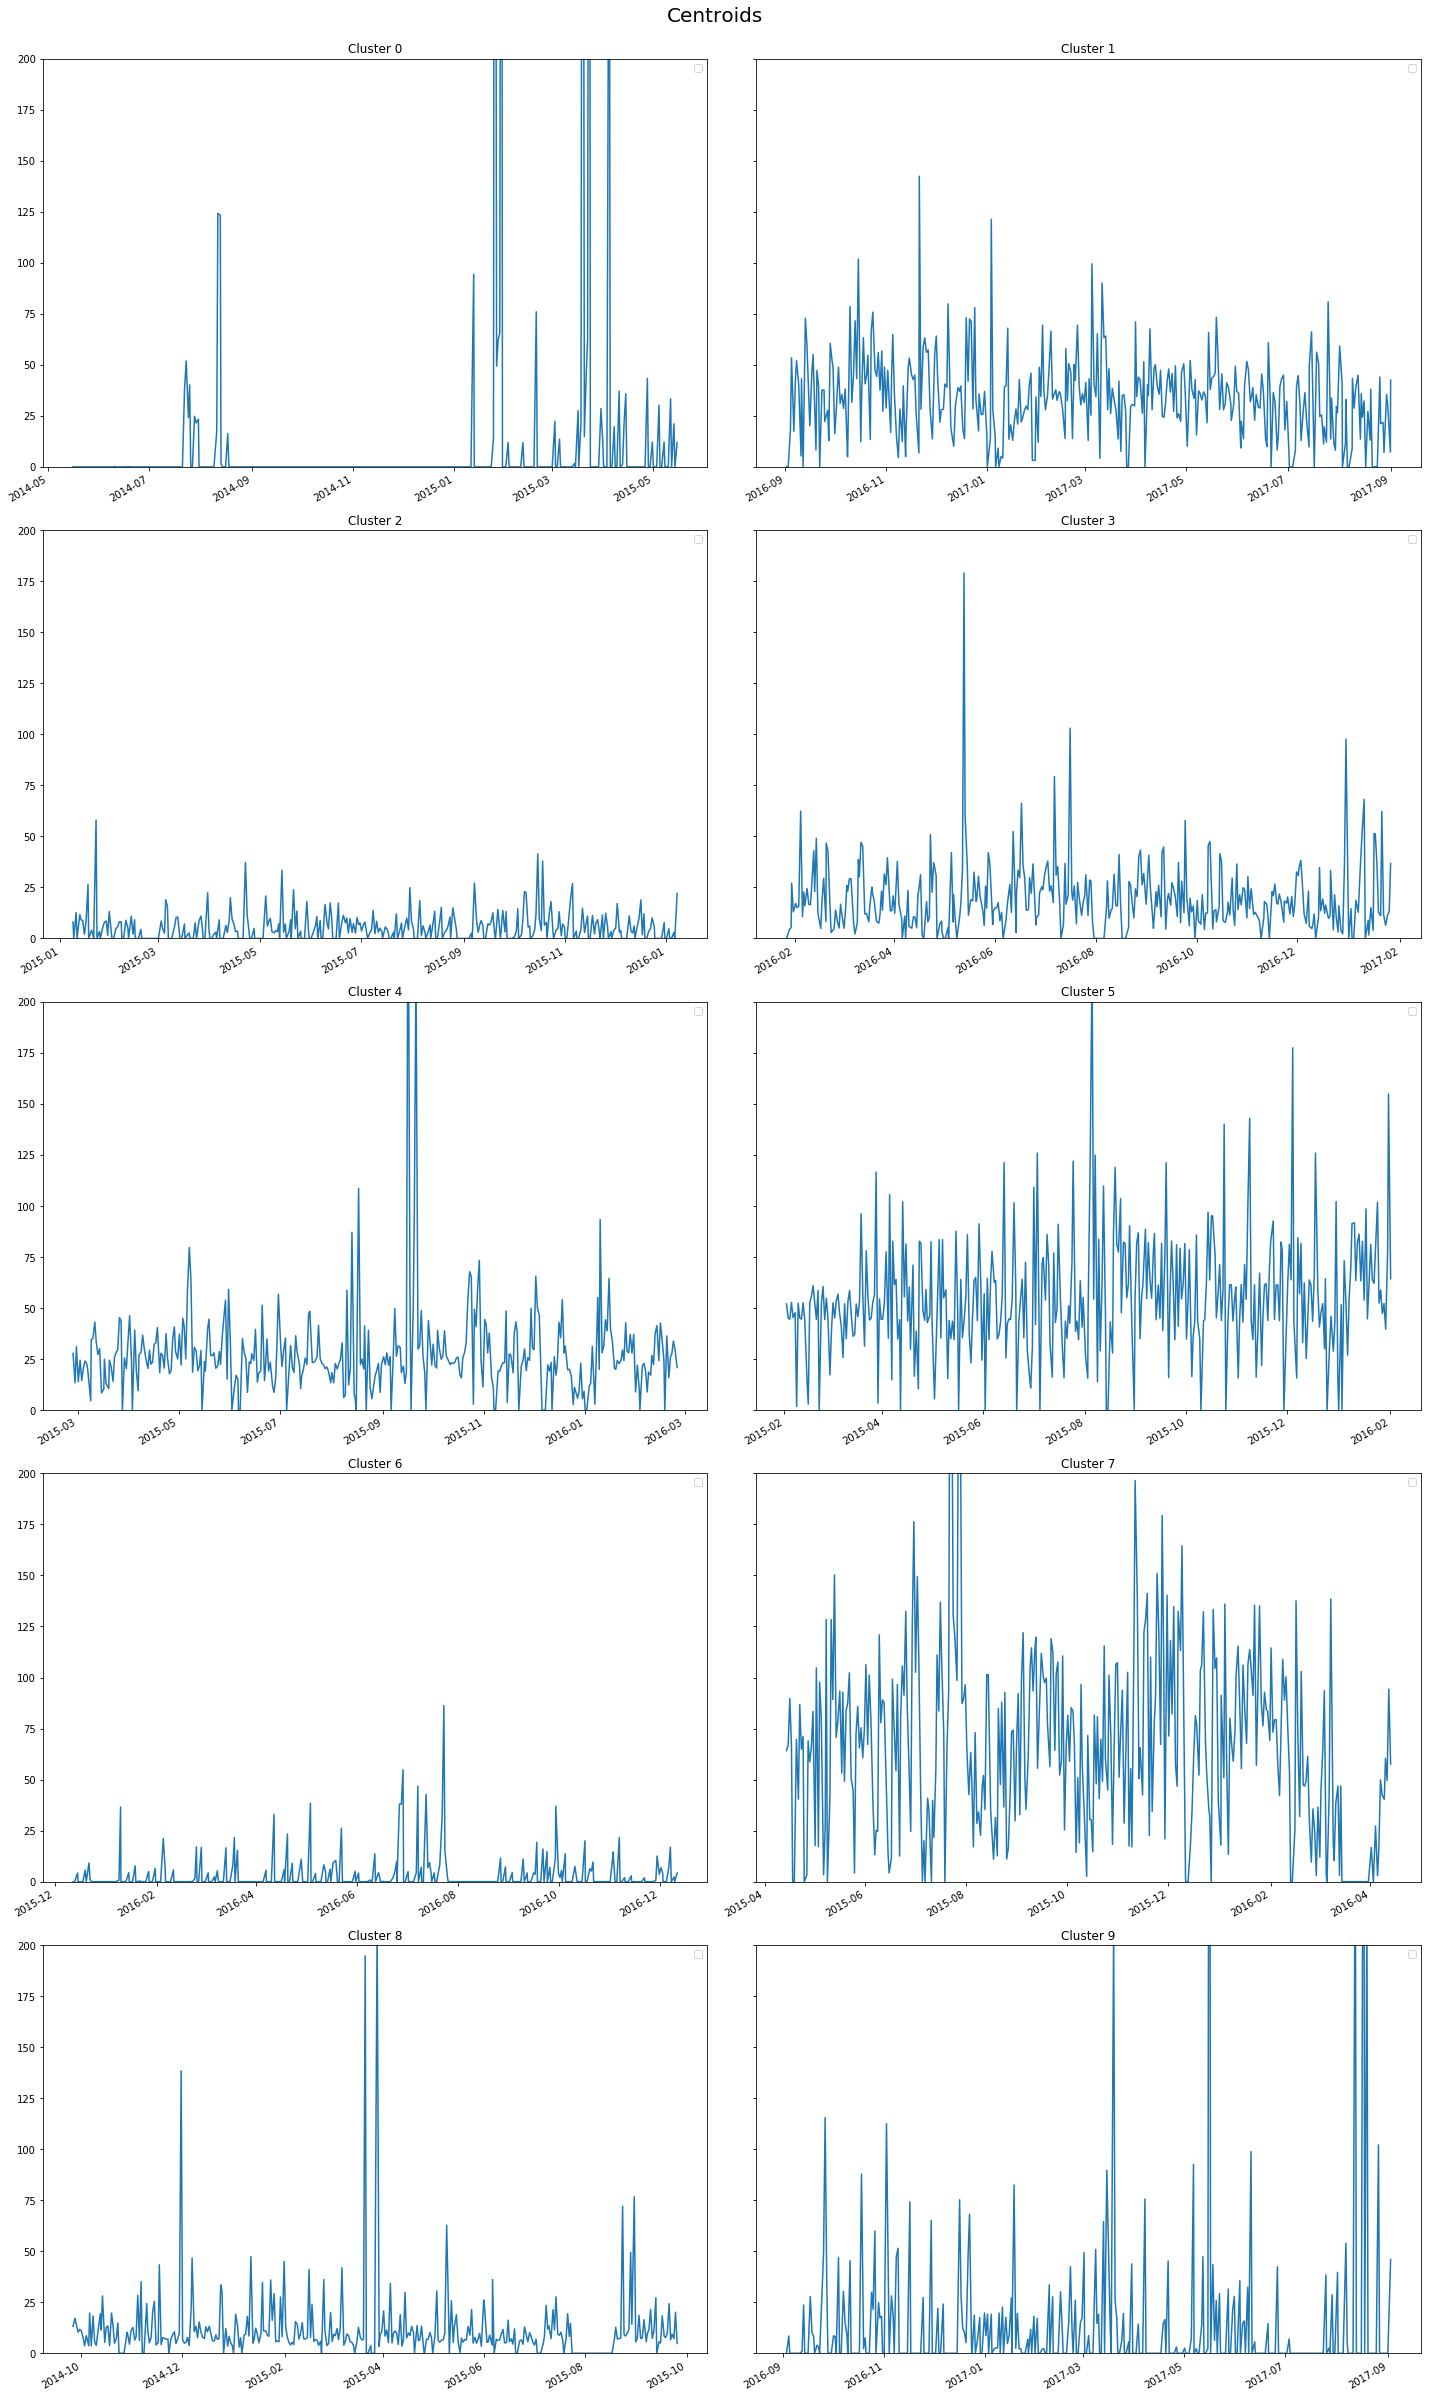

In [16]:
fig, ax = plt.subplots(5, 2, figsize=(20, 35), sharey=True)
for i in range(10):
    col = 'dist{}'.format(i)
    dist_min = vou_apriori[col].idxmin()
    temp = centroids.loc[(centroids['n_voucher']==dist_min[0]) & (centroids['annuality']==dist_min[1]), ['start_date', 'km_day']]
    temp.set_index('start_date', inplace=True)
    temp.plot(ax=ax[i//2, i%2])
    ax[i//2, i%2].legend('')
    ax[i//2, i%2].set_title('Cluster {}'.format(i))
    ax[i//2, i%2].set_ylim([0, 200])
    ax[i//2, i%2].set_xlabel('')
fig.suptitle('Centroids', fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.97]);
# fig.savefig('./reports/figures/clusters_centroids.png');

For example clusters 5 and 7 client type seem to be of people that travel a lot every day (maybe long distance commuters), with a higher average for cluster 7; while cluster 6 seems to represent people who use the car just some day (such as the weekends) and cluster 8 people who travel short distances daily (maybe people who work in the same city where they live and move by car) with some quite well distributed peaks (that may coincide with weekends).

### Total Mileage

Next I will answer this question: is there any new information in my clustering or is it the same as grouping annualities by their total mileage?

In order to do this I'll look at how the total mileage is distributed across my clustering and at the COR of annualities grouped by total mileage.

In [17]:
claims = pd.read_csv('./data/raw/claims.csv', sep=';')
claims['year'] = pd.to_datetime(claims['accident_date']).dt.year
claims['claim_cost'] = claims['claim_paid_amount'] + claims['claim_provision_amount']\
                        + claims['claim_paid_expenses'] + claims['claim_provision_expenses']
# capping claim cost over 20000€
claims['claim_cost'] = claims['claim_cost'].clip_upper(20000)

In [18]:
for cov in claims['coverage'].unique():
    vou_apriori[cov.strip()] = claims.loc[(claims['coverage']==cov)].groupby(['n_voucher', 'year'])['n_claim'].count()
    vou_apriori[cov.strip()] = vou_apriori[cov.strip()].fillna(0)

In [19]:
for cov in claims['coverage'].unique():
    col = '{}_cost'.format(cov.strip())
    vou_apriori[col] = claims.loc[(claims['coverage']==cov)].groupby(['n_voucher', 'year'])['claim_cost'].sum()
    vou_apriori[col] = vou_apriori[col].fillna(0)

This are some statistics about mileage for each cluster, as you can see the mileages are very different for some clusters and they are higher for clusters with high COR, so it makes sense to ask the question above.

However notice also that there some clusters that have very similar average mileages but different CORs (0 and 2, 3 and 9): this may be interesting to investigate further.

In [20]:
vou_apriori['km_tot'] = vouchers.groupby(['n_voucher', 'annuality'])['km_day_sum'].sum()
vou_apriori.groupby('label').agg({'km_tot':['mean', 'max', 'min', 'std', 'median', 'count']})

km_tot                                                      
               mean         max       min          std      median  count
label                                                                    
0       4520.904990   58166.018     0.000  4559.506300   3249.7535  70198
1      12752.573159   66017.725  1809.812  4419.935763  12629.8720  69601
2       4070.825985   40356.106    32.274  2833.536984   3370.8550  70779
3       8494.987141   48078.162   807.224  3892.593798   7905.1330  96259
4       9936.085782   49732.852  1209.561  3990.032168   9565.9465  41306
5      16261.477490   61130.359  2599.667  5339.232879  16349.2220  49629
6       3208.614670   36908.226     2.420  2763.870819   2474.4125  69040
7      23340.586478  117157.363  2946.460  9099.088036  22560.2980  41739
8       5975.736035   44354.091   288.263  3408.667597   5228.2150  71781
9       8338.684295   82685.332   256.843  5160.140864   7247.3225  89150

Now I'm going to group annualities by total mileage and see how the COR is distributed across this groups.

In [21]:
vou_apriori['km_cut'] = pd.cut(vou_apriori['km_tot'], [-1, 1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 30000, 1000000])

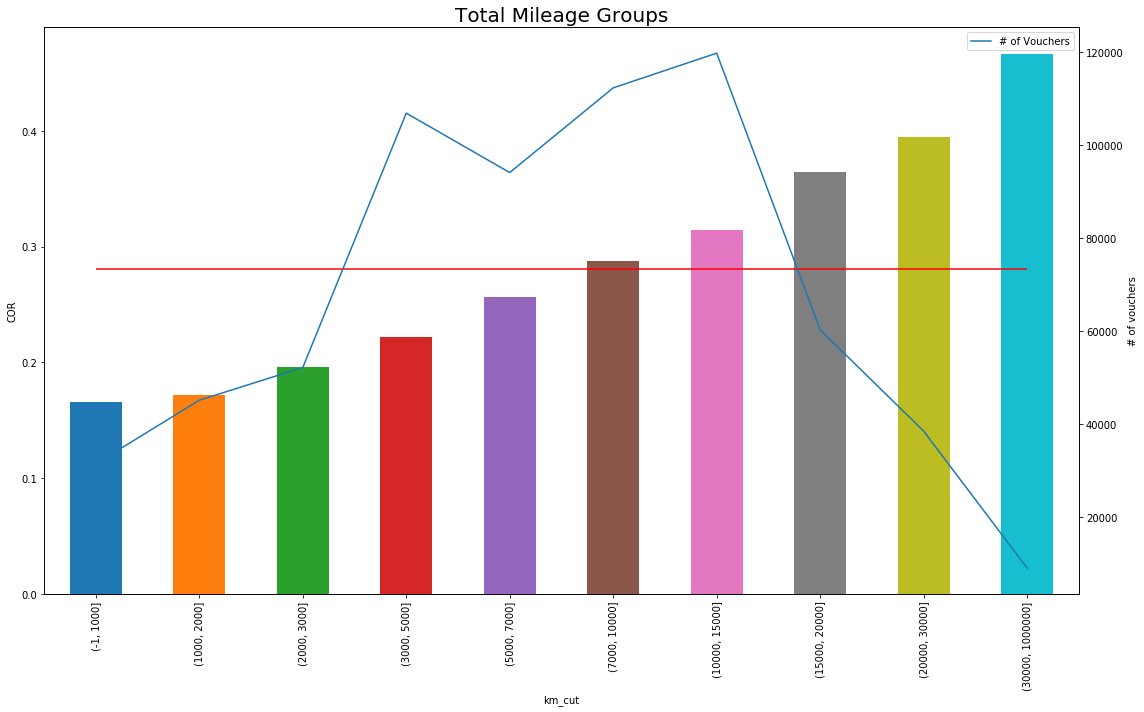

In [22]:
fig, ax = plt.subplots(figsize=(16, 10))
(vou_apriori.groupby('km_cut')['claims_cost'].sum() / vou_apriori.groupby('km_cut')['premium'].sum()).plot(kind='bar', ax=ax, label = '')
ax.hlines(vou_apriori['claims_cost'].sum() / vou_apriori['premium'].sum(), 0, 9, colors='r', label='Mean COR')
ax.set_ylabel('COR')
ax.set_title('Total Mileage Groups', fontsize=20)

ax2 = ax.twinx()
ax2.set_ylabel('# of vouchers')
(vou_apriori.groupby('km_cut')['n_claims'].count()).plot(kind='line', ax=ax2, label='# of Vouchers')
ax2.legend()

fig.tight_layout();
# fig.savefig('./reports/figures/COR_total_mil.png');

In this clustering the COR is clearly increasing with the total mileage, but notice how the higher COR corresponds to smaller and smaller clusters. Meanwhile the clustering obtained using apriori features yields a bigger "bad" cluster, thus giving us a somewhat more accurate information.

Another way of looking at this is by inspecting the distribution of the COR over the same total mileage groups as above, but focusing just on the worst cluster, e.g. cluster 7:

In [23]:
cluster = 7

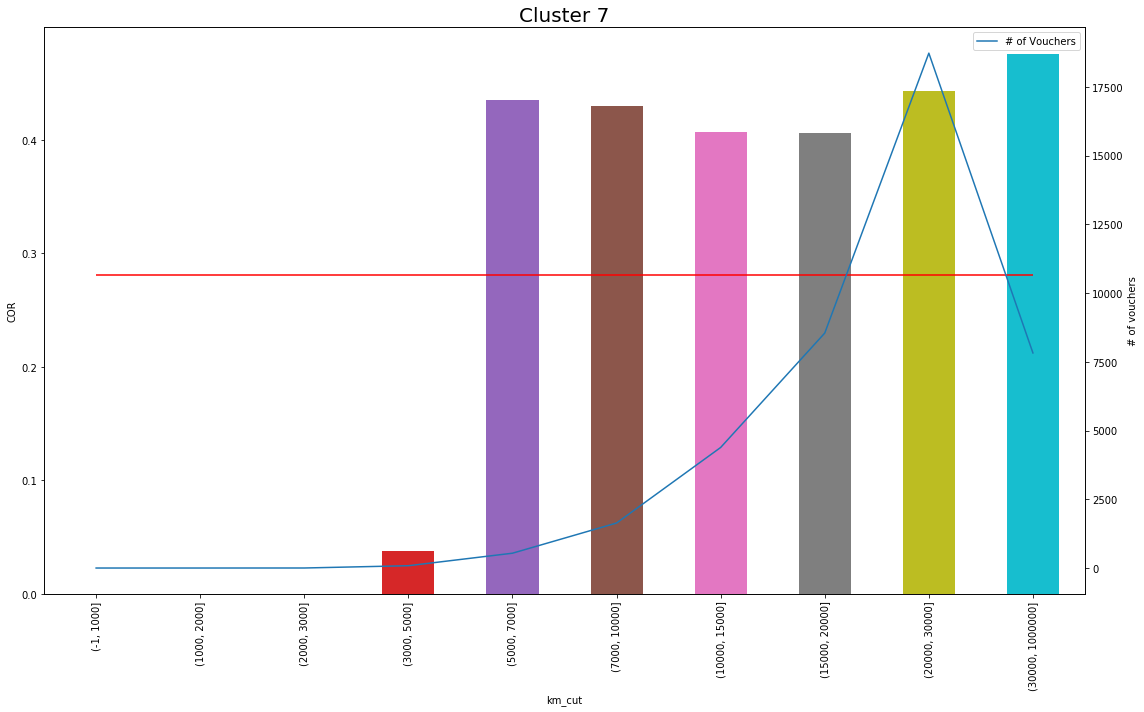

In [24]:
temp = vou_apriori.loc[(vou_apriori['label']==cluster), ['km_cut', 'claims_cost', 'premium']]

fig, ax = plt.subplots(figsize=(16, 10))
(temp.groupby('km_cut')['claims_cost'].sum() / temp.groupby('km_cut')['premium'].sum()).plot(kind='bar', ax=ax, label = '')
ax.hlines(vou_apriori['claims_cost'].sum() / vou_apriori['premium'].sum(), 0, 9, colors='r', label='Mean COR')
ax.set_ylabel('COR')
ax.set_title('Cluster 7', fontsize=20)

ax2 = ax.twinx()
ax2.set_ylabel('# of vouchers')
(temp.groupby('km_cut')['premium'].count()).plot(kind='line', ax=ax2, label='# of Vouchers')
ax2.legend()

fig.tight_layout();
# fig.savefig('./reports/figures/COR_total_mil_clust{}.png'.format(cluster));

In the plot above it's clear that in this cluster high COR annualities are spread quite evenly across the total mileages groups: the peak in number of annualities is for the range $(20000, 30000]$, whose COR is higher than the respective group on all the annualities. This indicates that the clustering identifies the annualities with high CORs indipendently of the total mileage; the fact that the clusters with the higher CORs are the ones with higher average total mileages depends just on the fact that who drives the most has more probability of filing a claim.

This can be seen also by looking at the same plot for a cluster with low COR, where the groups with higher total mileages have nevertheless low CORs. 

In [25]:
cluster = 2

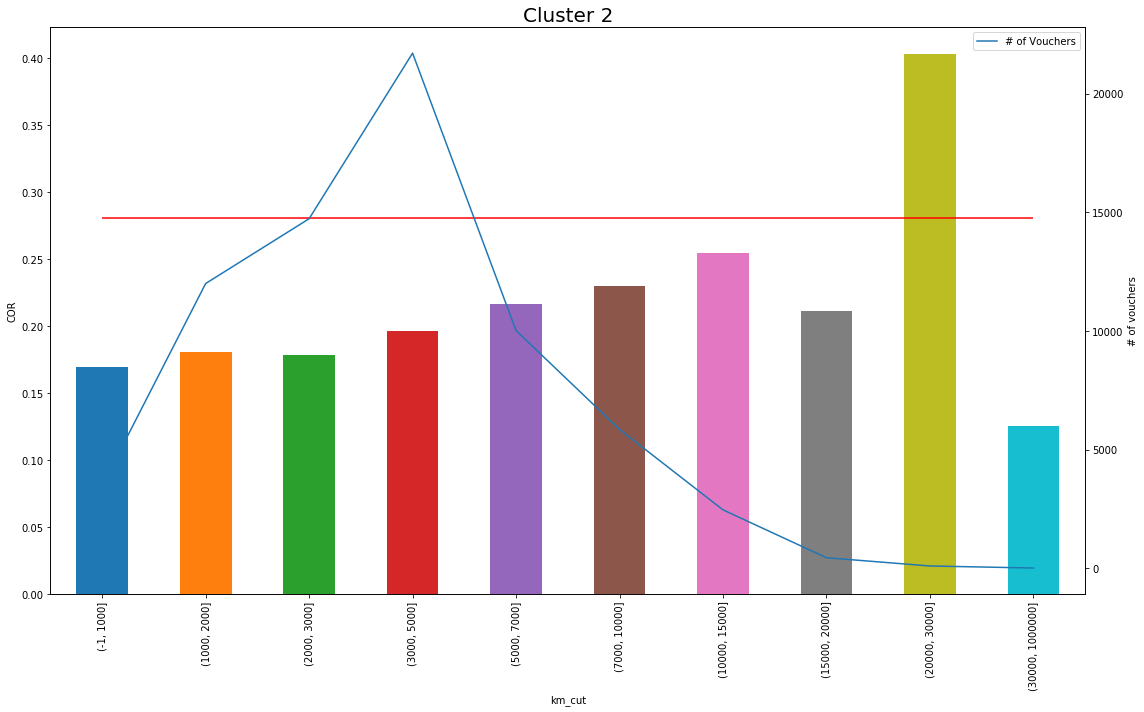

In [26]:
temp = vou_apriori.loc[(vou_apriori['label']==cluster), ['km_cut', 'claims_cost', 'premium']]

fig, ax = plt.subplots(figsize=(16, 10))
(temp.groupby('km_cut')['claims_cost'].sum() / temp.groupby('km_cut')['premium'].sum()).plot(kind='bar', ax=ax, label = '')
ax.hlines(vou_apriori['claims_cost'].sum() / vou_apriori['premium'].sum(), 0, 9, colors='r', label='Mean COR')
ax.set_ylabel('COR')
ax.set_title('Cluster 2', fontsize=20)

ax2 = ax.twinx()
ax2.set_ylabel('# of vouchers')
(temp.groupby('km_cut')['premium'].count()).plot(kind='line', ax=ax2, label='# of Vouchers')
ax2.legend()

fig.tight_layout();
# fig.savefig('./reports/figures/COR_total_mil_clust{}.png'.format(cluster));

Another thing that could be argued is that the annualities in clusters with high (or low) CORs that have no claims (or some) might be clients that, in other years, have had a cost for the insurance company and had just a lucky (or unlucky) year. One way to check this assumption could be to verify some of this cases, for example the one(s) in the range $(20000, 30000]$ in the plot above.

### Claims' Distribution

Finally I'm checking if there are some differences among the clusters in terms of claims number and type of claims (i.e. different type of complaints, such as theft, car accidents...).

In [27]:
vou_apriori.groupby('label').agg({'km_tot':['mean', 'max', 'min', 'std', 'median'],
                                 'n_claims':['mean', 'max', 'min', 'std', 'median']})

km_tot                                                 n_claims  \
               mean         max       min          std      median      mean   
label                                                                          
0       4520.904990   58166.018     0.000  4559.506300   3249.7535  0.180660   
1      12752.573159   66017.725  1809.812  4419.935763  12629.8720  0.237410   
2       4070.825985   40356.106    32.274  2833.536984   3370.8550  0.145283   
3       8494.987141   48078.162   807.224  3892.593798   7905.1330  0.199805   
4       9936.085782   49732.852  1209.561  3990.032168   9565.9465  0.205370   
5      16261.477490   61130.359  2599.667  5339.232879  16349.2220  0.263697   
6       3208.614670   36908.226     2.420  2763.870819   2474.4125  0.128187   
7      23340.586478  117157.363  2946.460  9099.088036  22560.2980  0.335322   
8       5975.736035   44354.091   288.263  3408.667597   5228.2150  0.167649   
9       8338.684295   82685.332   256.843  5160.140864   7247.3225  0.167572   

                                   
        max  min       std median  
label                              
0      14.0  0.0  0.543647    0.0  
1       9.0  0.0  0.581652    0.0  
2      10.0  0.0  0.448845    0.0  
3      11.0  0.0  0.527655    0.0  
4       7.0  0.0  0.535279    0.0  
5      11.0  0.0  0.622384    0.0  
6       6.0  0.0  0.425977    0.0  
7      20.0  0.0  0.728828    0.0  
8       8.0  0.0  0.481831    0.0  
9      13.0  0.0  0.486888    0.0

Here I plot the overall number of claims per annuality vs. the number of claims per annuality for each cluster; there seem to be a slight difference between higher COR clusters and the other distributions, but nothing too conclusive.

In [28]:
df = pd.DataFrame()
for i in range(10):
    temp = vou_apriori.loc[vou_apriori['label']==i, 'n_claims'].value_counts()
    col = 'label{}'.format(i)
    df[col] = (temp / temp.sum())
temp = vou_apriori['n_claims'].value_counts()
df['All'] = (temp / temp.sum())

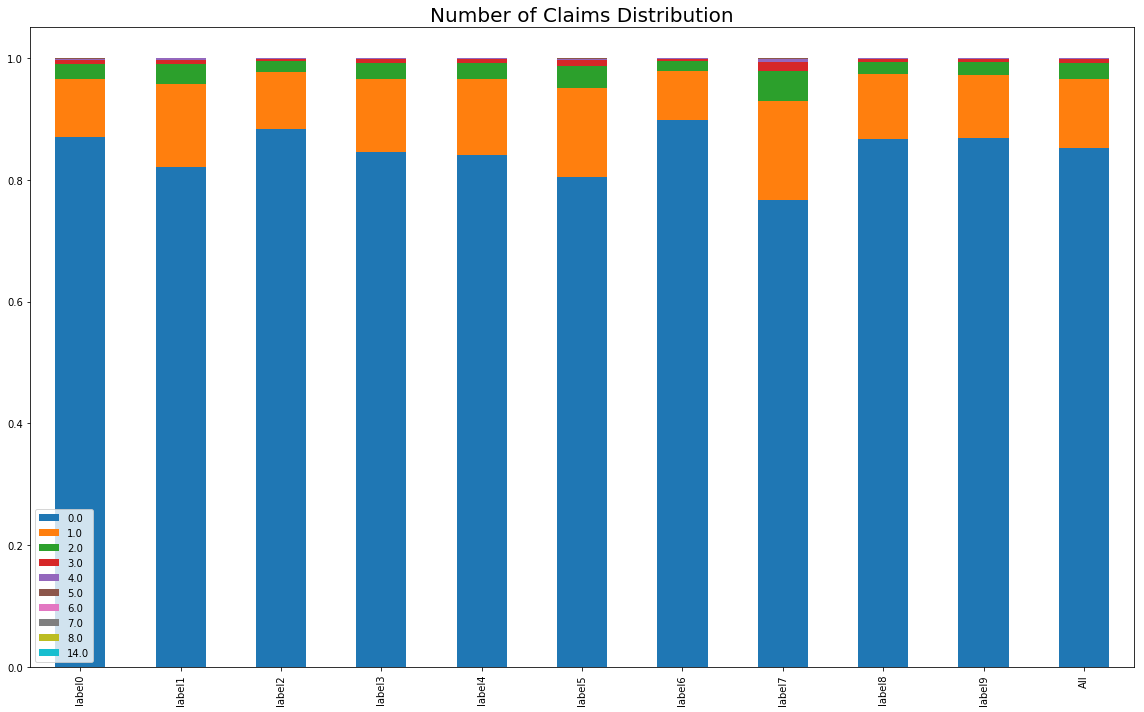

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
df.T.plot.bar(ax=ax, stacked=True)
plt.title('Number of Claims Distribution', fontsize=20)
fig.tight_layout();
# fig.savefig('./reports/figures/n_claims.png');

Here I do the same as above for the number of claims by type; again there are some differences amont the clusters but nothing too definite.

In [34]:
df = pd.DataFrame()
for i in range(10):
    den = vou_apriori.loc[vou_apriori['label']==i, 'n_claims'].sum()
    cols = ['RCA', 'ASSISTEXT', 'ATTIEVENT', 'ASSISTCB', 'CRISTALLI', 'COLLIS', 'INCFURTO', 'TUTLEG', 'INFORTUNI']
    temp = vou_apriori.loc[vou_apriori['label']==i, cols].sum()
    col = 'label{}'.format(i)
    df[col] = (temp / den)
den = vou_apriori['n_claims'].sum()
cols = ['RCA', 'ASSISTEXT', 'ATTIEVENT', 'ASSISTCB', 'CRISTALLI', 'COLLIS', 'INCFURTO', 'TUTLEG', 'INFORTUNI']
temp = vou_apriori[cols].sum()
df['All'] = (temp / den)

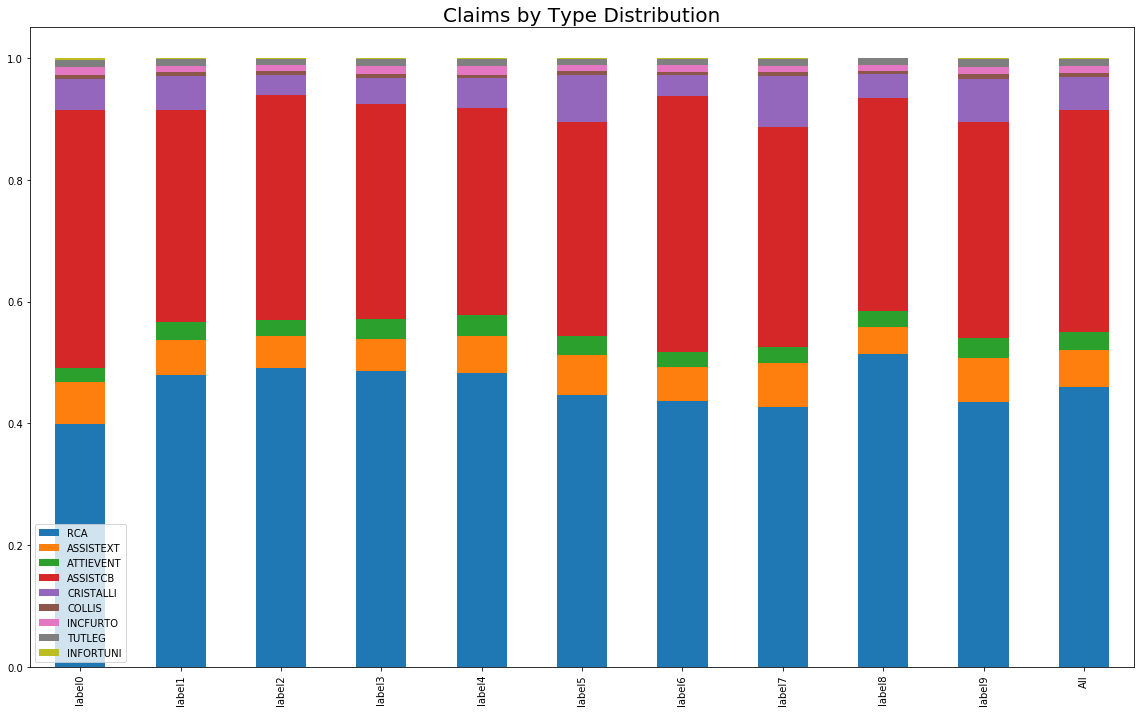

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
df.T.plot.bar(ax=ax, stacked=True)
plt.title('Claims by Type Distribution', fontsize=20)
fig.tight_layout();
# fig.savefig('./reports/figures/claim_types.png');

### Some other stuff I might try out

Another thing I could play with is trying to improve the overall COR by twitching the premiums for each cluster: this is the overall COR

In [42]:
cor = vou_apriori['claims_cost'].sum() / vou_apriori['premium'].sum()
cor_p5_7 = vou_apriori['claims_cost'].sum() / ((vou_apriori.loc[vou_apriori['label']==7, 'premium']*1.05).sum() + vou_apriori.loc[vou_apriori['label']!=7, 'premium'].sum())
cor_p5_7_5 = vou_apriori['claims_cost'].sum() / ((vou_apriori.loc[vou_apriori['label'].isin([5, 7]), 'premium']*1.05).sum() + vou_apriori.loc[~vou_apriori['label'].isin([5, 7]), 'premium'].sum())
cor_p5_7_m1_6 = vou_apriori['claims_cost'].sum() / ((vou_apriori.loc[vou_apriori['label']==7, 'premium']*1.05).sum() + (vou_apriori.loc[vou_apriori['label']==6, 'premium']*0.99).sum() + vou_apriori.loc[~vou_apriori['label'].isin([7, 6]), 'premium'].sum())
cor_p5_7_5_m1_6_2 = vou_apriori['claims_cost'].sum() / ((vou_apriori.loc[vou_apriori['label'].isin([5, 7]), 'premium']*1.05).sum() + (vou_apriori.loc[vou_apriori['label'].isin([6, 2]), 'premium']*0.99).sum() + vou_apriori.loc[~vou_apriori['label'].isin([7, 5, 6, 2]), 'premium'].sum())

In [55]:
print('Overall COR: {:.6f}\n5% increase cluster 7: {:.6f}\n5% increase cluster 7, 1% discount cluster 6: {:.6f}\n5% increase cluster 7 and 5: {:.6f}\n5% increase cluster 7 and 5, 1% discount cluster 6 and 2: {:.6f}'\
      .format(cor, cor_p5_7, cor_p5_7_m1_6, cor_p5_7_5, cor_p5_7_5_m1_6_2))

Overall COR: 0.280615
5% increase cluster 7: 0.279553
5% increase cluster 7, 1% discount cluster 6: 0.279797
5% increase cluster 7 and 5: 0.278388
5% increase cluster 7 and 5, 1% discount cluster 6 and 2: 0.278882


In [59]:
print('5% increase cluster 7: {:.0f}€\n5% increase cluster 7, 1% discount cluster 6: {:.0f}€\n5% increase cluster 7 and 5: {:.0f}€\n5% increase cluster 7 and 5, 1% discount cluster 6 and 2: {:.0f}€'\
      .format((cor-cor_p5_7)*340e6, (cor-cor_p5_7_m1_6)*340e6, (cor-cor_p5_7_5)*340e6, (cor-cor_p5_7_5_m1_6_2)*340e6))

5% increase cluster 7: 361094€
5% increase cluster 7, 1% discount cluster 6: 278037€
5% increase cluster 7 and 5: 757311€
5% increase cluster 7 and 5, 1% discount cluster 6 and 2: 589409€


The gain doesn't seem too marked, but the denominator used for the COR is equal to over 340,000,000€, so a 0.0008 improvement is worth almost 300,000€! (Agreed, this isn't that much if you're making 300 millions euros, and agreed bis I'm not taking into account that some of the clients might go away if their premiums go up (but I could anyway argue that it might be beneficial after all), but it's always money...)

## Conclusions

In this project I used some techniques to analyze data about, using to try and predict how.

The final score is, which...

## Further Analysis

If I had more time I would have tried:

- something
- something
- something